In [1]:
pip install ucimlrepo

In [4]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# EDA - ANALISE EXPLORATORIA DE DADOS

In [6]:
statlog_german_credit_data = fetch_ucirepo(id=144)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

print(statlog_german_credit_data.metadata)
print(statlog_german_credit_data.variables)


print(X.info())
print(y.info())

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [7]:
#estatistica de features

print(X.describe())

        Attribute2    Attribute5   Attribute8  Attribute11  Attribute13  \
count  1000.000000   1000.000000  1000.000000  1000.000000  1000.000000   
mean     20.903000   3271.258000     2.973000     2.845000    35.546000   
std      12.058814   2822.736876     1.118715     1.103718    11.375469   
min       4.000000    250.000000     1.000000     1.000000    19.000000   
25%      12.000000   1365.500000     2.000000     2.000000    27.000000   
50%      18.000000   2319.500000     3.000000     3.000000    33.000000   
75%      24.000000   3972.250000     4.000000     4.000000    42.000000   
max      72.000000  18424.000000     4.000000     4.000000    75.000000   

       Attribute16  Attribute18  
count  1000.000000  1000.000000  
mean      1.407000     1.155000  
std       0.577654     0.362086  
min       1.000000     1.000000  
25%       1.000000     1.000000  
50%       1.000000     1.000000  
75%       2.000000     1.000000  
max       4.000000     2.000000  


In [8]:
#analise de desbalanceamento de classes

print(y['class'].value_counts(normalize=True))

class
1    0.7
2    0.3
Name: proportion, dtype: float64


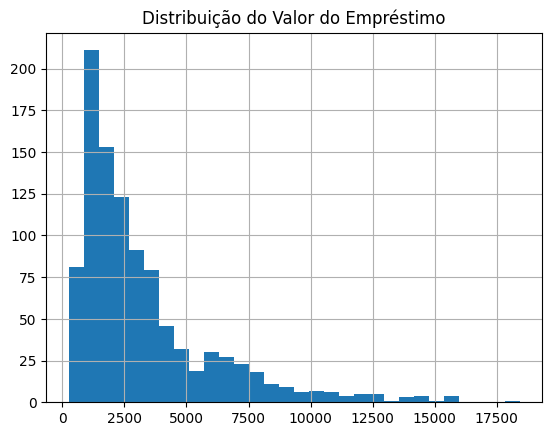

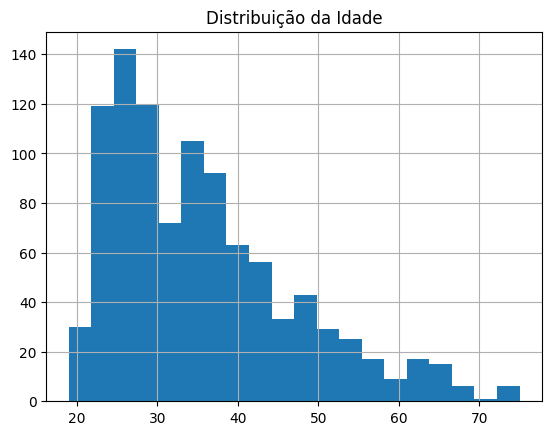

In [10]:
# Plotar histograma para 'credit_amount'
X['Attribute5'].hist(bins=30)
plt.title('Distribuição do Valor do Empréstimo')
plt.show()

# Plotar histograma para 'age'
X['Attribute13'].hist(bins=20)
plt.title('Distribuição da Idade')
plt.show()

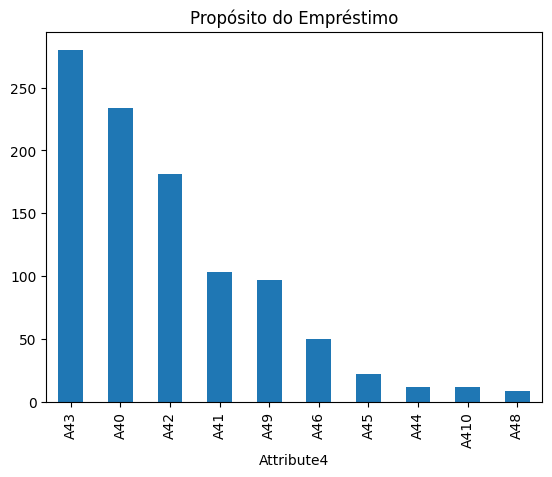

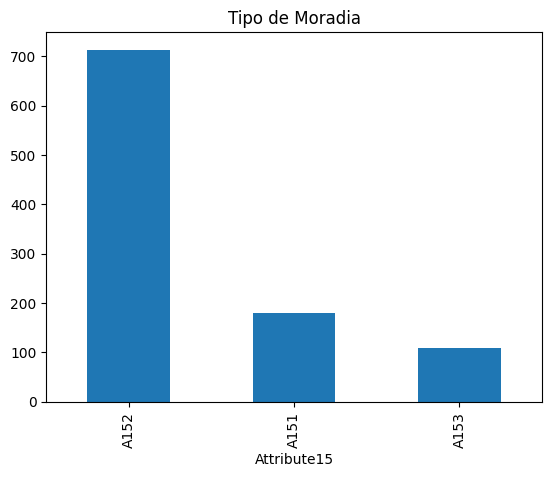

In [12]:
# Plotar gráfico de barras para 'purpose'
X['Attribute4'].value_counts().plot(kind='bar')
plt.title('Propósito do Empréstimo')
plt.show()

# Plotar gráfico de barras para 'housing'
X['Attribute15'].value_counts().plot(kind='bar')
plt.title('Tipo de Moradia')
plt.show()

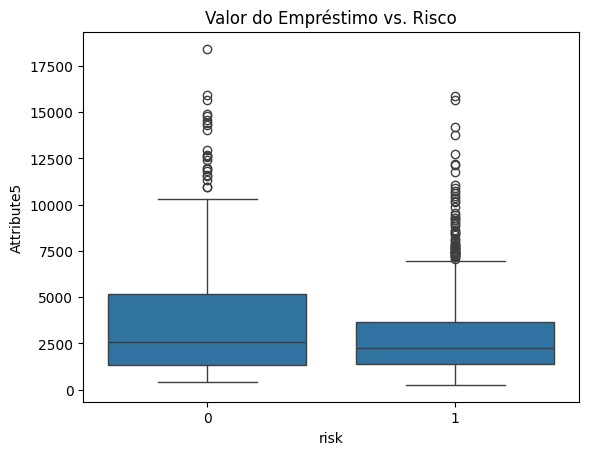

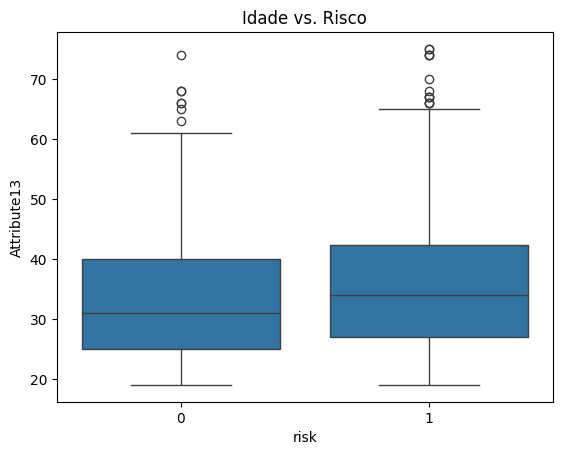

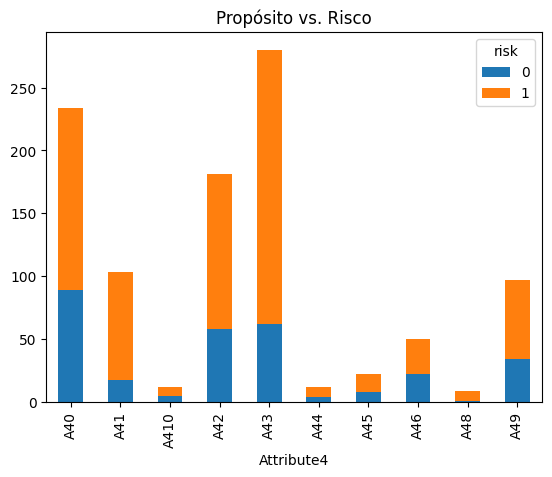

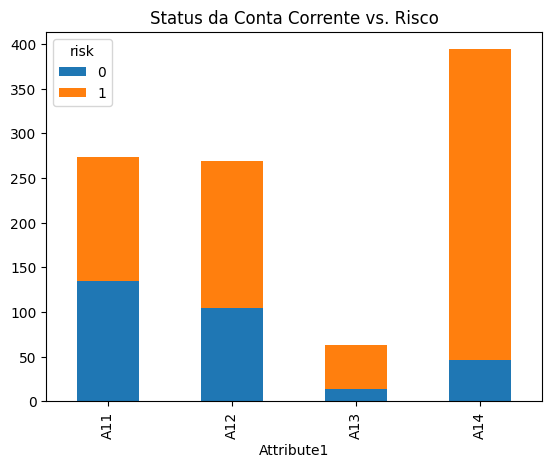

In [15]:
X_copy = X.copy()
y_copy = y.copy()

# 0 (Alto Risco) e 1 -> 1 (Baixo Risco)
# O metadata diz: 1 = good, 2 = bad. Vamos mudar 2 para 0 (bad)
y_copy['risk'] = y_copy['class'].map({1: 1, 2: 0}) # 1 = Bom Risco, 0 = Alto Risco (Bad)

# Juntar
df_full = pd.concat([X_copy, y_copy['risk']], axis=1)

import seaborn as sns

# O 'credit_amount' é diferente para "Bom" e "Alto" risco?
sns.boxplot(data=df_full, x='risk', y='Attribute5')
plt.title('Valor do Empréstimo vs. Risco')
plt.show()

# A 'age' é diferente?
sns.boxplot(data=df_full, x='risk', y='Attribute13')
plt.title('Idade vs. Risco')
plt.show()

pd.crosstab(df_full['Attribute4'], df_full['risk']).plot(kind='bar', stacked=True)
plt.title('Propósito vs. Risco')
plt.show()

# O 'checking_status' afeta o risco?
pd.crosstab(df_full['Attribute1'], df_full['risk']).plot(kind='bar', stacked=True)
plt.title('Status da Conta Corrente vs. Risco')
plt.show()

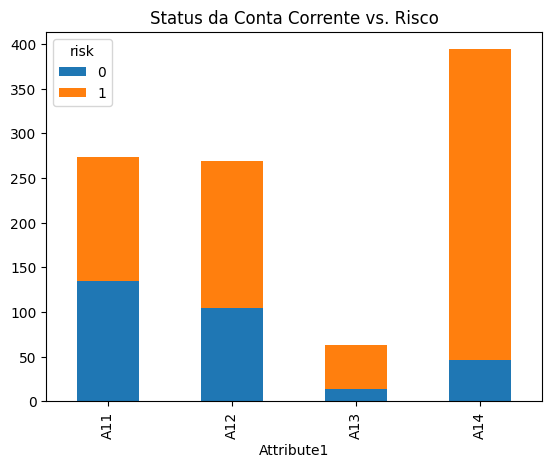

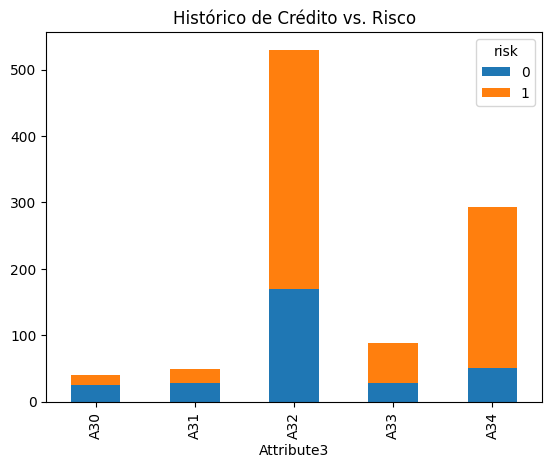

In [16]:
# 'Attribute1' (Status da Conta) vs. 'risk'
pd.crosstab(df_full['Attribute1'], df_full['risk']).plot(kind='bar', stacked=True)
plt.title('Status da Conta Corrente vs. Risco')
plt.show()

# 'Attribute3' (Histórico de Crédito) vs. 'risk'
pd.crosstab(df_full['Attribute3'], df_full['risk']).plot(kind='bar', stacked=True)
plt.title('Histórico de Crédito vs. Risco')
plt.show()

In [17]:
X_processed = pd.get_dummies(X)
y_processed = y['class'].map({1: 1, 2: 0}) # 1 = Bom Risco, 0 = Alto Risco

print("Formato do X original:", X.shape)
print("Formato do X processado:", X_processed.shape)
print("\nClasses do Y processado:\n", y_processed.value_counts())

Formato do X original: (1000, 20)
Formato do X processado: (1000, 61)

Classes do Y processado:
 class
1    700
0    300
Name: count, dtype: int64


### Resumo da Análise Exploratória de Dados (EDA)


### 1. As Principais Descobertas

1.  **O Alvo é Desbalanceado:** Composto por **70% de clientes de "Risco Bom"** (classe 1) e **30% de "Risco Ruim"** (classe 2).
    * **Por que isso importa:** Isso força a focar em métricas melhores, como o **Recall**, especialmente porque o *metadata* informa que é 5x pior aprovar um cliente "Ruim".

2.  **Os Dados são Mistos (Numéricos e Texto):** `X` tinha 20 colunas, sendo **7 numéricas** (`int64`) e **13 categóricas** (`object`, ou seja, texto).

3.  **Dados Estão Completos:** nenhum valor faltante (nulo) nas 1000 linhas.

4.  **Existem Preditores Visuais Fortes:** gráficos mostraram "descrepâncias grandes"
    * **Por que isso importa:** `Attribute3` (Histórico de Crédito) e `Attribute1` (Status da Conta) separam visualmente o Risco Bom do Ruim. Por exemplo, a categoria 'A34' (conta crítica) tinha uma proporção muito alta de "Risco Ruim" (azul). Mostra confiança de que o modelo terá "sinal" para aprender.

---


### 2. Preparação para o Modelo

1.  **Mapeamento de Alvo** `y` para `y_processed`, onde **0 = Risco Ruim** e **1 = Risco Bom**.
2.  **Features:** `pd.get_dummies(X)` para transformar as 13 colunas de texto em colunas numéricas (0s e 1s), criando o `X_processed` com 61 colunas.


# Divisão e Treinamento de modelo

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y_processed,
    test_size=0.2,
    random_state=42,
    stratify=y_processed
)

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")
print("\nDistribuição do y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição do y_test:")
print(y_test.value_counts(normalize=True))

tree_model = DecisionTreeClassifier(random_state=42)

tree_model.fit(X_train, y_train)

Formato de X_train: (800, 61)
Formato de X_test: (200, 61)

Distribuição do y_train:
class
1    0.7
0    0.3
Name: proportion, dtype: float64

Distribuição do y_test:
class
1    0.7
0    0.3
Name: proportion, dtype: float64


DecisionTreeClassifier(random_state=42)

In [26]:
tree_model_v2 = DecisionTreeClassifier(
    max_depth=3,
    random_state=42
)

# 2. Treinar o novo modelo
tree_model_v2.fit(X_train, y_train)
print("--- Resultados do Modelo V2 (max_depth=3) ---")
y_pred_v2 = tree_model_v2.predict(X_test)

print(classification_report(y_test, y_pred_v2, target_names=['Risco Ruim (0)', 'Risco Bom (1)']))

--- Resultados do Modelo V2 (max_depth=3) ---
                precision    recall  f1-score   support

Risco Ruim (0)       0.50      0.07      0.12        60
 Risco Bom (1)       0.71      0.97      0.82       140

      accuracy                           0.70       200
     macro avg       0.60      0.52      0.47       200
  weighted avg       0.65      0.70      0.61       200



{acc:2f}
[[ 29  31]
 [ 34 106]]


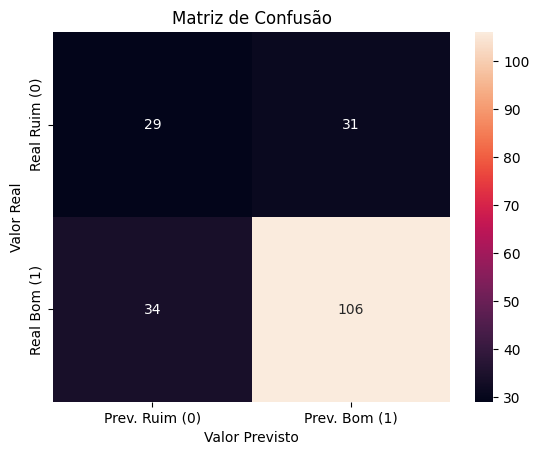

                precision    recall  f1-score   support

Risco Ruim (0)       0.46      0.48      0.47        60
 Risco Bom (1)       0.77      0.76      0.77       140

      accuracy                           0.68       200
     macro avg       0.62      0.62      0.62       200
  weighted avg       0.68      0.68      0.68       200



In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

y_pred = tree_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("{acc:2f}")

cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Prev. Ruim (0)', 'Prev. Bom (1)'], yticklabels=['Real Ruim (0)', 'Real Bom (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Risco Ruim (0)', 'Risco Bom (1)']))

                precision    recall  f1-score   support

Risco Ruim (0)       0.46      0.75      0.57        60
 Risco Bom (1)       0.85      0.62      0.72       140

      accuracy                           0.66       200
     macro avg       0.66      0.69      0.64       200
  weighted avg       0.73      0.66      0.67       200



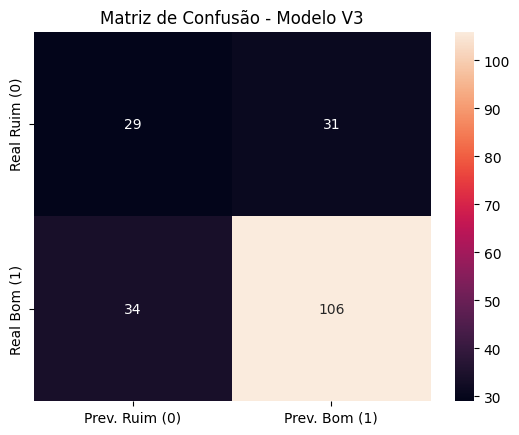

In [25]:
tree_model_v3 = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)

tree_model_v3.fit(X_train, y_train)
y_pred_v3 = tree_model_v3.predict(X_test)

print(classification_report(y_test, y_pred_v3, target_names=['Risco Ruim (0)', 'Risco Bom (1)']))

cm_v3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_v3, annot=True, fmt='d', xticklabels=['Prev. Ruim (0)', 'Prev. Bom (1)'], yticklabels=['Real Ruim (0)', 'Real Bom (1)'])
plt.title('Matriz de Confusão - Modelo V3')
plt.show()


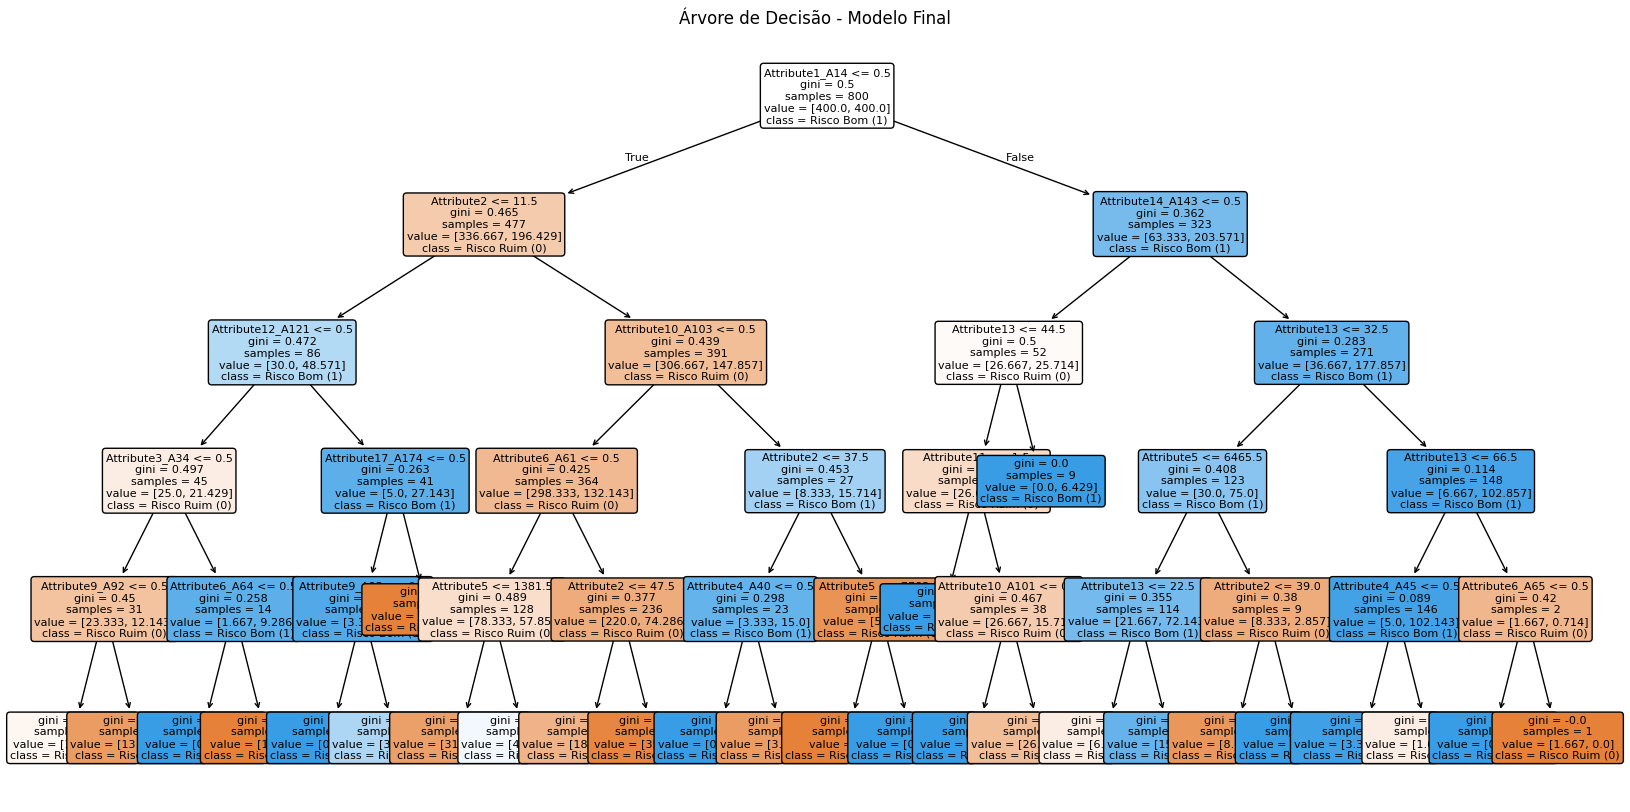

In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

feature_names = X_processed.columns

plot_tree(
    tree_model_v3,
    feature_names=feature_names,
    class_names=['Risco Ruim (0)', 'Risco Bom (1)'],
    filled=True,
    rounded=True,
    fontsize=8
)

plt.title("Árvore de Decisão - Modelo Final")
plt.show()

In [28]:
import joblib

joblib.dump(tree_model_v3, 'modelo_risco_credito,pkl')

print("Modelo salvo!")

Modelo salvo!
